In [221]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch

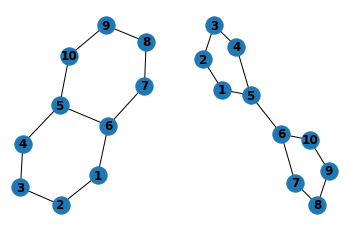

In [260]:
alpha = nx.Graph()
beta = nx.Graph()

alpha.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 1), (6, 7), (7, 8), (8, 9), (9, 10), (10, 5)])
beta.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 5), (5, 1), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 6)])
subax1 = plt.subplot(121)
nx.draw(alpha, with_labels=True, font_weight='bold')
subax2 = plt.subplot(122)
nx.draw(beta, with_labels=True, font_weight='bold')

In [261]:
def compare_vector_lists(list1, list2):
    if len(list1) != len(list2):
        return 0

    # Create a copy of list2
    remaining_vectors = list2[:]

    for vector1 in list1:
        found = 0

        for vector2 in remaining_vectors:
            if vector1 == vector2:
                found = 1
                remaining_vectors.remove(vector2)
                break

        if not found:
            return 0

    return 1

# Example usage:
list1 = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
list2 = [[7, 8, 9], [1, 2, 3], [4, 0, 6]]
compare_vector_lists(list1, list2)



def find_vector_index(vectors, p):
    # vectors has form of [[1, 2, 3], [4, 6]] (list of vectors) format, and p has form [[1, 2, 3], [4, 5]]
    index_set = []
    for k in range(len(p)):
        index = []
        for i, vector in enumerate(vectors):
            for j in p[k]:
                if j in vector:
                    index.append(i)
        index_set.append(index)
    return index_set
# Example usage:
vectors = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
p = [[1, 4, 9], [2, 6]]
result = find_vector_index(vectors, p) # the result of this is [[0, 1, 2], [0, 1]] 

def categorize_dictionary(dictionary):
    categories = []

    for key, lst in dictionary.items():
        found = False

        for category in categories:
            if compare_vector_lists(lst, category[0][1]):
                category.append((key, lst))
                found = True
                break

        if not found:
            categories.append([(key, lst)])
    cat_keys = []
    for category in categories:
        keys = []
        for key, _ in category:
            keys.append(key)
        cat_keys.append(keys)

    return cat_keys

# Example usage:
dictionary = {
    1: [[1, 2, 3], [4, 5, 6], [7, 8, 9]],
    2: [[7, 8, 9], [1, 2, 3], [4, 5, 6]],
    3: [[4, 5, 6], [1, 2, 3], [7, 8, 9]],
    4: [[10, 11, 12], [13, 14, 15]],
    5: [[7, 8, 9], [1, 2, 3], [4, 5, 6]],
    6: [[16, 17, 18], [19, 20, 21]],
    7: [[13, 14, 15], [10, 11, 12]]
}

result = categorize_dictionary(dictionary) # the result is [[1, 2, 3, 5], [4, 7], [6]]



In [314]:
def findPaths(G,u,n):
    #u: source node.  n: path length
    if n==0:
        return [[u]]
    paths = []
    for neighbor in G.neighbors(u):
        for path in findPaths(G,neighbor,n-1):
            if u not in path:
                paths.append([u]+path)
    return paths

def node_path_lengths_set(G):
    #G is a nx.graph, can compute either from G=nx.Graph or G=nx.from_numpy_matrix(A) where A is adjacency matrix
    """this returns the list of aggregated nodes by the function hash(num_of_all_paths_of_length_n, previous color)
    """
    node_path_lengths = {}
    for i in range(1, len(G) + 1):
        num_of_paths = []
        for j in range(len(G)):
            num = len(findPaths(G, i, j))
            num_of_paths.append(num)  
        node_path_lengths[i] = num_of_paths
    node_path_lengths = [list(node_path_lengths[i]) for i in range(1, len(node_path_lengths) + 1)]
    return node_path_lengths
      
def all_path_length_poset(G):
    #G is a nx.graph, can compute either from G=nx.Graph or G=nx.from_numpy_matrix(A) where A is adjacency matrix
    """this returns the list of aggregated nodes by the hash(num_of_shortest_paths, previous color)
    """ 
    p = np.array(node_path_lengths_set(G)).T
    class_set = {}
    d_1 = []
    for j in list(set(p[0])):
        t = [i + 1 for i, n in enumerate(p[0]) if n == j]
        d_1.append(t)
    class_set[0] = d_1
    for k in range(1, len(G._node)):
        d = []
        num_previous_class = len(class_set[k - 1])  
        for i in range(num_previous_class):
            new_class_index = class_set[k - 1][i]  #pick the class nodes to be refined
            new_class = [ p[k][v - 1] for v in new_class_index ]  #cat the corresponding labels
            for j in list(set(new_class)):
                #refine the previous class by the number of paths of length k
                t = [new_class_index[i] for i, n in enumerate(new_class) 
                     if n == j] #bin the same labels, i.e., refine the class by num_paths
                
                # refine the class by the colors of paths of length k
                pathset = {}
                previous_color_set = {}
                for m in t:
                    pathset[m] = findPaths(G, m, k)
                    previous_color = find_vector_index(class_set[k - 1], pathset[m])
                    previous_color_set[m] = previous_color
                
                #t: contains the nodes of the currrent class,
                #pathset: contains the paths of current class of length k
                #previous_color_set: contains the colors of the paths labeled in the previous color set
                
                refined_by_color = categorize_dictionary(previous_color_set)
                for q in range(len(refined_by_color)):
                    d.append(refined_by_color[q])
                
        class_set[k] = d
        if class_set[k] == class_set[k - 1]:
            class_set.popitem()
            break
            
    return class_set
    
        

In [322]:
np.array(node_path_lengths_set(alpha)).T

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [2, 2, 2, 2, 3, 3, 2, 2, 2, 2],
       [3, 2, 2, 3, 4, 4, 3, 2, 2, 3],
       [4, 3, 3, 4, 4, 4, 4, 3, 3, 4],
       [4, 5, 5, 4, 4, 4, 4, 5, 5, 4],
       [5, 6, 6, 5, 4, 4, 5, 6, 6, 5],
       [4, 4, 4, 4, 2, 2, 4, 4, 4, 4],
       [3, 4, 4, 3, 2, 2, 3, 4, 4, 3],
       [3, 3, 3, 3, 2, 2, 3, 3, 3, 3],
       [3, 2, 2, 3, 2, 2, 3, 2, 2, 3]])

In [325]:
all_path_length_poset(alpha)

{0: [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]],
 1: [[1, 2, 3, 4, 7, 8, 9, 10], [5, 6]],
 2: [[2, 3, 8, 9], [1, 4, 7, 10], [5, 6]]}

In [326]:
all_path_length_poset(beta)

{0: [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]],
 1: [[1, 2, 3, 4, 7, 8, 9, 10], [5, 6]],
 2: [[2, 3, 8, 9], [1, 4, 7, 10], [5, 6]]}

In [321]:
findPaths(alpha, 1, 4)

[[1, 2, 3, 4, 5], [1, 6, 5, 4, 3], [1, 6, 5, 10, 9], [1, 6, 7, 8, 9]]

In [324]:
def categorize_dictionary(dictionary):
    categories = []

    for key, lst in dictionary.items():
        found = False

        for category in categories:
            if compare_vector_lists(lst, category[0][1]):
                category.append((key, lst))
                found = True
                break

        if not found:
            categories.append([(key, lst)])
    cat_keys = []
    for category in categories:
        keys = []
        for key, _ in category:
            keys.append(key)
        cat_keys.append(keys)

    return cat_keys

# Example usage:
dictionary = {
    1: [[1, 2, 3], [4, 5, 6], [7, 8, 9]],
    2: [[7, 8, 9], [1, 2, 3], [4, 5, 6]],
    3: [[4, 5, 6], [1, 2, 3], [7, 8, 9]],
    4: [[10, 11, 12], [13, 14, 15]],
    5: [[7, 8, 9], [1, 2, 3], [4, 5, 6]],
    6: [[16, 17, 18], [19, 20, 21]],
    7: [[13, 14, 15], [10, 11, 12]]
}

result = categorize_dictionary(dictionary) # the result is [[1, 2, 3, 5], [4, 7], [6]]
